In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import keras
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers.merge import Multiply
from keras.models import Model
from keras.layers.merge import Concatenate, Add
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D, AveragePooling1D
from keras.layers.convolutional import UpSampling1D, UpSampling2D
from keras.regularizers import l2, l1, l1_l2
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.recurrent import LSTM
from keras import backend as K
import tensorflow as tf

def set_keras_num_threads(n_threads):
    from keras import backend as K
    import tensorflow as tf
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.intra_op_parallelism_threads = n_threads
    config.inter_op_parallelism_threads = n_threads
    K.set_session(tf.Session(config=config))
    
set_keras_num_threads(2)

import h5py

/home/shibinbin/apps/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
class Motif(object):
    def __init__(self, length=3, alphabet='ATCG'):
        self.length = length
        self.alphabet = np.asarray(list(alphabet), dtype='U1')
        self.pwm = np.exp(np.random.uniform(size=(len(alphabet), length))*10.0)
        self.pwm /= np.sum(self.pwm, axis=0, keepdims=True)
        self.cumpwm = np.cumsum(self.pwm, axis=0)
        self.cumpwm[-1, :] += 0.1
        self.consensus = ''.join(self.alphabet[np.argmax(self.pwm, axis=0)])
    
    def set_pwm(self, pwm, alphabet='ATCG'):
        '''
        Args:
            pwm: matrix of shape (alphabet_size, motif_length)
        '''
        self.alphabet = np.asarray(list(alphabet), dtype='U1')
        self.pwm = pwm
        self.length = pwm.shape[1]
        self.cumpwm = np.cumsum(self.pwm, axis=0)
        self.cumpwm[-1, :] += 0.1
        self.consensus = ''.join(self.alphabet[np.argmax(self.pwm, axis=0)])
        
    def print_pwm(self):
        print('\t'.join(list(self.alphabet)))
        for i in range(self.length):
            print('\t'.join(['%.6f'%a for a in self.pwm[:, i]]))
            
    def sample(self, length, size=1):
        assert length >= self.length
        X = np.random.randint(len(self.alphabet), size=(size, length))
        p = np.random.uniform(size=(size, len(self.alphabet), self.length))
        motifs = np.argmax(p < self.cumpwm[np.newaxis, :, :], axis=1)
        positions = np.random.randint(length - self.length + 1, size=size)
        for i in range(size):
            X[i, positions[i]:(positions[i] + self.length)] = motifs[i]
        X = (X[:, :, np.newaxis] == np.arange(len(self.alphabet))[np.newaxis, np.newaxis, :]).astype(np.float32)
        #sequences = [''.join(a) for a in np.take(self.alphabet, X)]
        return X, positions

    def sample_negative(self, length, size=1):
        X = np.random.randint(len(self.alphabet), size=(size, length))
        X = (X[:, :, np.newaxis] == np.arange(len(self.alphabet))[np.newaxis, np.newaxis, :]).astype(np.float32)
        return X

motif_length = 10
window_size = 128
motif = Motif(length=motif_length)
print('consensus: ', motif.consensus)
print('PWM: ')
motif.print_pwm()
n_samples = 10000
X_pos, positions = motif.sample(length=window_size, size=n_samples)
X_neg = motif.sample_negative(length=window_size, size=n_samples)
X = np.concatenate([X_pos, X_neg], axis=0)
y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])
positions = np.concatenate([positions, np.full(n_samples, -1)])
random_indices = np.random.permutation(X.shape[0])
X = X[random_indices]
y = y[random_indices]
positions = positions[random_indices]

with h5py.File('synthetic_motifs.h5', 'w') as f:
    f.create_dataset('pwm', data=motif.pwm)
    f.create_dataset('alphabet', data=motif.alphabet.astype('S1'))
    f.create_dataset('X', data=X, compression=True)
    f.create_dataset('y', data=y, compression=True)
    f.create_dataset('positions', data=positions)
#for sequence, position in zip(*motif.sample(length=20, size=10)):
    #print(position, sequence)
#ax.pcolor(motif.pwm, cmap=cm.RdBu_r)
#fig, ax = plt.subplots(figsize=(8, 3))
#ax.pcolor(np.swapaxes(X, 1, 2).reshape((-1, 20)), cmap=cm.Greys)

consensus:  TTTACTCGAA
PWM: 
A	T	C	G
0.012221	0.628171	0.062260	0.297348
0.275465	0.379688	0.011729	0.333119
0.001092	0.531993	0.040385	0.426530
0.714679	0.274134	0.004513	0.006674
0.010680	0.200169	0.416010	0.373142
0.003323	0.804241	0.191730	0.000707
0.003325	0.125196	0.869098	0.002381
0.001144	0.260893	0.002379	0.735584
0.648202	0.101948	0.008338	0.241511
0.781510	0.155934	0.053527	0.009029


In [306]:
motif.alphabet.astype('S1')

array([b'A', b'T', b'C', b'G'], dtype='|S1')

(0, 1)

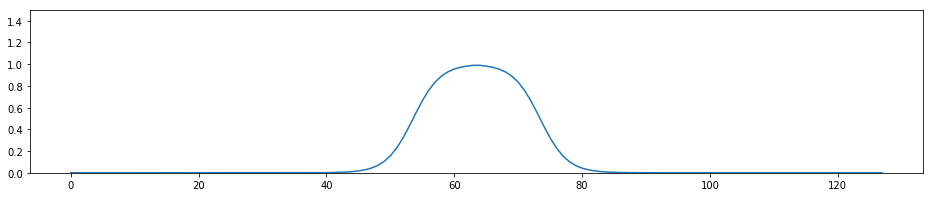

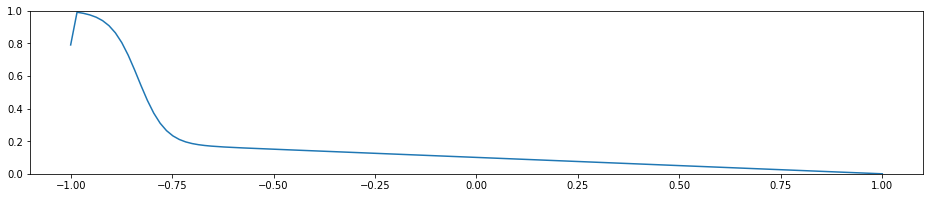

In [262]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def soft_window_numpy(x, w=1, c=0, t=10.0):
    y_curve = np.where(x <= c,
                       sigmoid(t*(x - (c - 0.5*w))),
                       sigmoid(t*(-x + (c + 0.5*w))))
    return y_curve

def soft_window2(x, w=0.5, c=0, k=0.25, t=10.0):
    y_curve = np.where(x <= c,
                       sigmoid(t*(x - (c - 0.5*w))),
                       sigmoid(t*(-x + (c + 0.5*w))))
    y_linear = np.where(x <= c, x + 1 - c, -x + 1 + c)
    y_linear = np.where(x <= c, (x + 1)/(c + 1), (x - 1)/(c - 1))
    return 0.8*y_curve + 0.2*y_linear

x = np.linspace(-1, 1, 128, dtype=np.float32)
window = soft_window_numpy(x, c=64/64 - 1, w=20*2/128, t=30.0)
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(np.arange(128), window)
ax.set_ylim(0, 1.5)

x = np.linspace(-1, 1, 128, dtype=np.float32)
window2 = soft_window2(x, c=-0.99, w=20*2/128, k=0.1, t=30.0)
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(x, window2)
ax.set_ylim(0, 1)

In [235]:
def conv_network(input_layer):
    output = Conv1D(64, 8, padding='valid', kernel_regularizer=l2(0.0005))(input_layer)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Conv1D(64, 4, padding='valid', kernel_regularizer=l2(0.0005))(output)
    output = Activation('relu')(output)
    output = MaxPooling1D(2)(output)
    output = Flatten()(output)
    #output = Dense(64, kernel_regularizer=l2(0.0001))(output)
    return output

def soft_window(x, c, w, t):
    c = K.reshape(c, (-1, 1))
    w = K.reshape(w, (-1, 1))
    return K.switch(x <= c, 
                    K.sigmoid(t*(x - (c - 0.5*w))),
                    K.sigmoid(t*(-x + (c + 0.5*w))))
    
def direct_cnn(window_size=128, n_channels=4):
    input_layer = Input(shape=(window_size, n_channels))
    output = conv_network(input_layer)
    output = Dense(1)(output)
    output = Activation('sigmoid')(output)
    model = Model(inputs=[input_layer], outputs=[output])
    return model
    
def attention_cnn(window_size=128, n_channels=4, t=15.0):
    def attention_function(params):
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.reshape(params, (-1, 1))
        c = K.tanh(c)
        #c = K.reshape(params[:, 0], (-1, 1))
        #w = K.reshape(params[:, 1], (-1, 1))
        #w = K.exp(w)
        w = 20*2.0/window_size
        k = 0.001
        y_linear = [(x + 1)/(c + 1), (x - 1)/(c - 1)]
        y_linear = [(x + 1 - c), (-x + 1 + c)]
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, 
                     (1 - k)*y_curve[0] + k*y_linear[0],
                     (1 - k)*y_curve[1] + k*y_linear[1])
        y = K.expand_dims(y, axis=-1)
        return y
    
    input_layer = Input(shape=(window_size, n_channels))
    conv_attention = conv_network(input_layer)
    attention_params = Dense(64, name='attention_dense1', activation='relu')(conv_attention)
    attention_params = Dense(64, name='attention_dense2', activation='relu')(attention_params)
    attention_params = Dense(1, name='attention_params')(attention_params)
    attention = Lambda(attention_function, name='attention')(attention_params)
    weighted_input = Multiply(name='multiply_attention')([input_layer, attention])
    conv_predict = conv_network(weighted_input)
    output = Dense(1, kernel_regularizer=l2(0.0005))(conv_predict)
    output = Activation('sigmoid')(output)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model, attention_params, attention

def stochastic_attention_cnn(window_size=128, n_channels=4, t=10.0, 
                             n_sampler=10, sampler_stddev=1.0):
    def attention_function(params):
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.reshape(params, (-1, 1))
        c = K.tanh(c)
        #c = K.reshape(params[:, 0], (-1, 1))
        #w = K.reshape(params[:, 1], (-1, 1))
        #w = K.exp(w)
        w = 20*2.0/window_size
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, y_curve[0], y_curve[1])
        y = K.expand_dims(y, axis=-1)
        return y

    def attention_sampler(attention_params):
        n_samples = K.shape(attention_params)[0]
        noise = K.random_normal((n_samples, n_sampler, 1), stddev=sampler_stddev*50/window_size)
        attention_params = K.expand_dims(attention_params, axis=1)
        attention_params = attention_params + noise
        attention_params = K.reshape(attention_params, (-1, 1))
        
        c = attention_params
        x = np.linspace(-1, 1, window_size).astype(np.float32).reshape((1, window_size))
        c = K.tanh(c)
        w = 20*2.0/window_size
        y_curve  =  [K.sigmoid(t*(x - (c - 0.5*w))), K.sigmoid(t*(-x + (c + 0.5*w)))]
        y = K.switch(x <= c, y_curve[0], y_curve[1])
        y = K.expand_dims(y, axis=-1)
        return y
        
        
    input_layer = Input(shape=(window_size, n_channels))
    conv_attention = conv_network(input_layer)
    attention_params = Dense(64, name='attention_dense1', activation='relu')(conv_attention)
    attention_params = Dense(64, name='attention_dense2', activation='relu')(attention_params)
    attention_params = Dense(1, name='attention_params')(attention_params)
    
    attention = Lambda(lambda x: attention_sampler(x), name='attention_sampler')(attention_params)
    repeated_input = Lambda(lambda x: K.repeat_elements(x, n_sampler, axis=0),
                            name='repeated_input')(input_layer)
    weighted_input = Multiply(name='multiply_attention')([repeated_input, attention])
    conv_predict = conv_network(weighted_input)
    output = Dense(1, kernel_regularizer=l2(0.0005), name='output_dense')(conv_predict)
    output = Activation('sigmoid', name='output_sigmoid')(output)
    output = Lambda(lambda x: K.mean(K.reshape(x, (-1, n_sampler, 1)), axis=1), name='output_mean')(output)
    
    model = Model(inputs=[input_layer], outputs=[output])
    return model, attention_params, attention
    
#model, attention_params, attention = attention_cnn()

attention_model, attention_params, attention = stochastic_attention_cnn()
attention_model.summary()
attention_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 128, 4)       0                                            
__________________________________________________________________________________________________
conv1d_167 (Conv1D)             (None, 121, 64)      2112        input_53[0][0]                   
__________________________________________________________________________________________________
activation_202 (Activation)     (None, 121, 64)      0           conv1d_167[0][0]                 
__________________________________________________________________________________________________
max_pooling1d_167 (MaxPooling1D (None, 60, 64)       0           activation_202[0][0]             
__________________________________________________________________________________________________
conv1d_168

In [219]:
def gen_repeat_input(window_size, n_channels):
    input_layer = Input(shape=(window_size, n_channels))
    output = Lambda(lambda x: K.repeat_elements(x, 3, axis=0))(input_layer)
    return K.function([input_layer], [output])
repeat_input = gen_repeat_input(X.shape[1], X.shape[2])
repeated_X = repeat_input([X[:10]])[0]

In [223]:
np.all(repeated_X[0] == repeated_X[3])

False

In [237]:
attention_model.fit(X, y, batch_size=50, epochs=30)

Epoch 1/30
10000/10000 [==============================] - 3s 254us/step - loss: 0.6018 - acc: 0.7220
Epoch 2/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5979 - acc: 0.7245
Epoch 3/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5978 - acc: 0.7251
Epoch 4/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5972 - acc: 0.7278
Epoch 5/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5978 - acc: 0.7232
Epoch 6/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5962 - acc: 0.7262
Epoch 7/30
10000/10000 [==============================] - 2s 248us/step - loss: 0.5953 - acc: 0.7314
Epoch 8/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5940 - acc: 0.7322
Epoch 9/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5931 - acc: 0.7319
Epoch 10/30
10000/10000 [==============================] - 2s 249us/step - loss: 0.5941 - a

In [242]:
model = direct_cnn()
model.summary()
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X, y, batch_size=25, epochs=30)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 128, 4)            0         
_________________________________________________________________
conv1d_175 (Conv1D)          (None, 121, 64)           2112      
_________________________________________________________________
activation_212 (Activation)  (None, 121, 64)           0         
_________________________________________________________________
max_pooling1d_175 (MaxPoolin (None, 60, 64)            0         
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 57, 64)            16448     
_________________________________________________________________
activation_213 (Activation)  (None, 57, 64)            0         
_________________________________________________________________
max_pooling1d_176 (MaxPoolin (None, 28, 64)            0         
__________

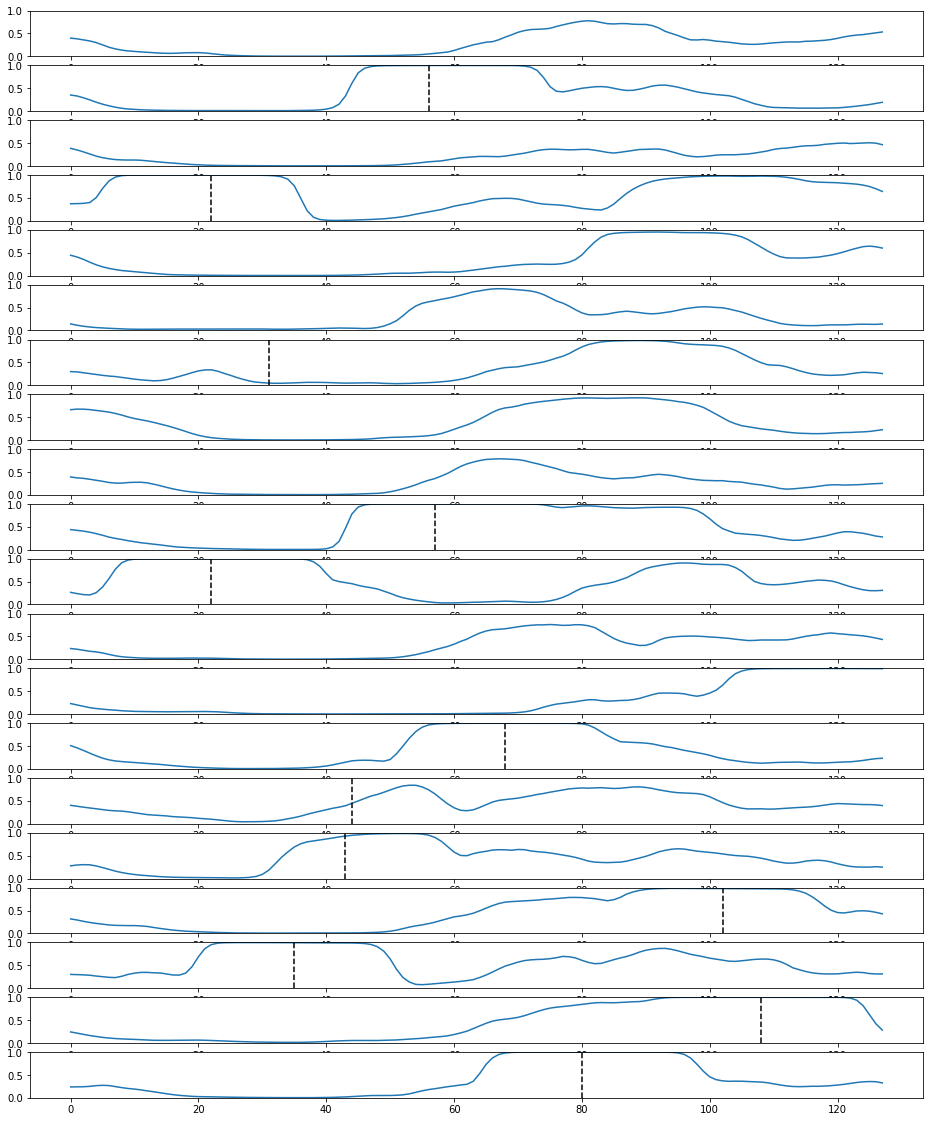

In [270]:
def masked_scan(model, X, w=30):
    window_size = X.shape[1]
    x = np.linspace(-1, 1, window_size, np.float32)
    windows = np.empty((window_size, window_size), np.float32)
    for i in range(window_size):
        windows[i] = soft_window_numpy(x, c=i/window_size*2 - 1, w=w*2/128, t=30.0)
    X2 = X[:, np.newaxis, :, :]*windows[np.newaxis, :, :, np.newaxis]
    X2 = X2.reshape((-1, window_size, X.shape[2]))
    y2 = model.predict(X2, batch_size=100)
    y2 = y2.reshape((-1, window_size))
    return y2

y_pred_masked = masked_scan(model, X[:20])
fig, axes = plt.subplots(20, 1, figsize=(16, 20))
for i in range(20):
    axes[i].plot(y_pred_masked[i])
    axes[i].set_ylim(0, 1)
    if positions[i] >= 0:
        axes[i].plot([positions[i] + 4, positions[i] + 4], [0, 1], color='k', linestyle='dashed')

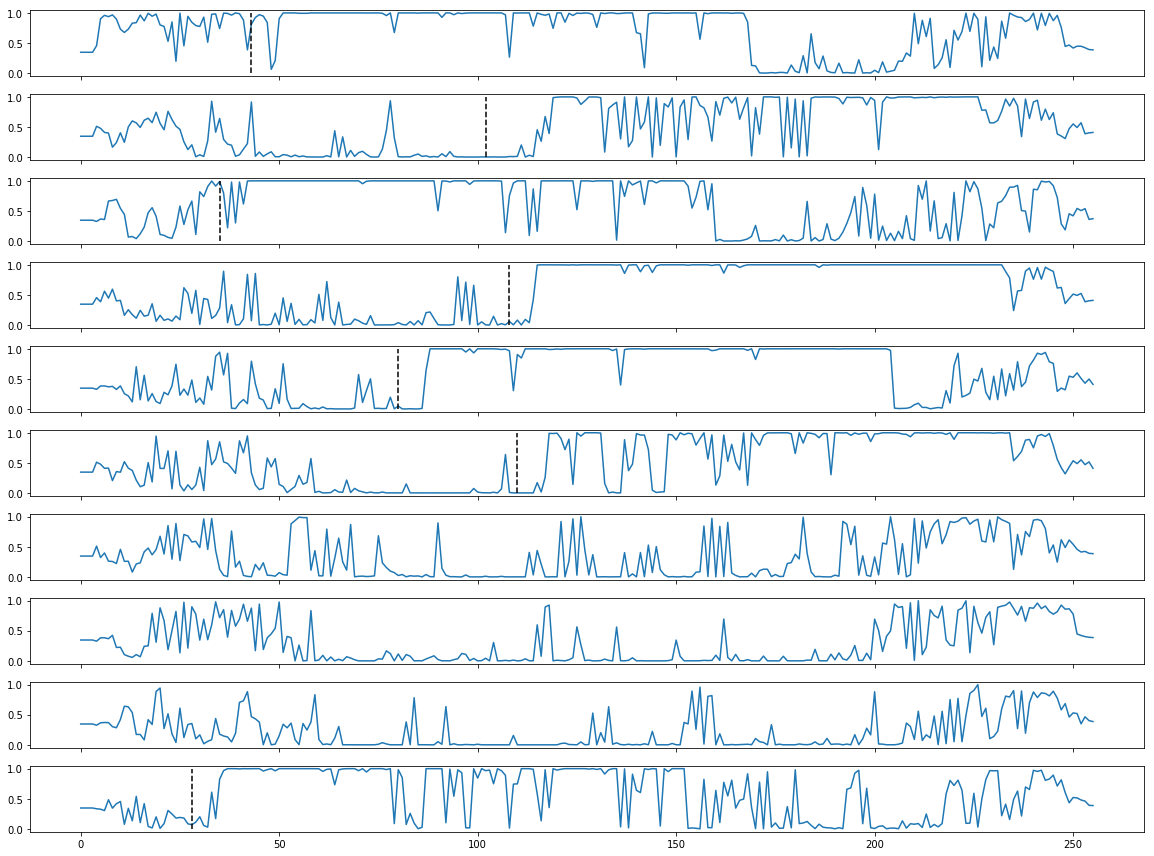

In [111]:
def onehot_encode(s, alphabet='ATCG'):
    alphabet = np.asarray(list(alphabet), dtype='U1')
    x = np.asarray(list(s), dtype='U1')
    encoded = (x[:, np.newaxis] == alphabet[np.newaxis, :]).astype(np.int32)
    return encoded

def onehot_decode(x, alphabet='ATCG'):
    alphabet = np.asarray(list(alphabet), dtype='U1')
    return ''.join(alphabet[np.argmax(x, axis=1)])
    
def scan_sequence(model, sequence, alphabet='ATCG', window_size=128):
    X_seq = np.zeros((window_size*2 + len(sequence), len(alphabet)), dtype=np.float32)
    X_seq[window_size:(window_size + len(sequence))] = onehot_encode(sequence)
    X_win = np.full((window_size + len(sequence), window_size, len(alphabet)), 0, dtype=np.float32)
    for i in range(window_size + len(sequence)):
        X_win[i] = X_seq[i:(i + window_size)]
    y = model.predict(X_win, batch_size=100)
    return y

fig, axes = plt.subplots(10, 1, figsize=(16, 12), sharex=True)
y_pred = np.zeros((10, 128*2, 1))
for i in range(10):
    j = i + 15
    y_pred[i] = scan_sequence(model, onehot_decode(X[j]))
    axes[i].plot(y_pred[i])
    if positions[j] >= 0:
        axes[i].plot([positions[j] + 4, positions[j] + 4], [0, 1], color='k', linestyle='dashed')
plt.tight_layout()

In [59]:
positions[5:15]

array([-1, 27, -1, -1, 53, 18, -1, -1, 64, 40])

In [65]:
from scipy.optimize import leastsq
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

class SoftWindowError(object):
    def __init__(self, X, t=10.0):
        self.X = X
        self.t = t
        
    def func(self, params):
        c, w = params
        t = self.t
        f = np.where(self.X <= c, 
                     sigmoid(t*( self.X - (c - 0.5*w))),
                     sigmoid(t*(-self.X + (c + 0.5*w))))
        return f
    
    def error(self, params):
        return self.func(params) - self.X
    
    def jac(self, params):
        c, w = params
        t = self.t
        f = self.func(params)
        d_f = f*(1 - f)
        d_c = np.where(self.X <= c, -1, 1)
        d_w = np.where(self.X <= c, 0.5, -0.5)
        return np.vstack([2*d_f*d_c, 2*d_f*d_w]).T

soft_window_error = SoftWindowError(np.squeeze(y_pred))
soft_window_error.func([1, 1]).shape

(10, 256)

In [268]:
np.vstack([np.ones(10), np.zeros(10)])

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [264]:
model.fit(X, y, epochs=10, batch_size=50)

Epoch 1/10
10000/10000 [==============================] - 2s 184us/step - loss: 0.1073 - acc: 0.9802
Epoch 2/10
10000/10000 [==============================] - 2s 179us/step - loss: 0.0976 - acc: 0.9836
Epoch 3/10
10000/10000 [==============================] - 2s 177us/step - loss: 0.0894 - acc: 0.9881
Epoch 4/10
10000/10000 [==============================] - 2s 177us/step - loss: 0.0857 - acc: 0.9902
Epoch 5/10
10000/10000 [==============================] - 2s 178us/step - loss: 0.0768 - acc: 0.9921
Epoch 6/10
10000/10000 [==============================] - 2s 186us/step - loss: 0.0701 - acc: 0.9950
Epoch 7/10
10000/10000 [==============================] - 2s 191us/step - loss: 0.0659 - acc: 0.9973
Epoch 8/10
10000/10000 [==============================] - 2s 184us/step - loss: 0.0644 - acc: 0.9957
Epoch 9/10
10000/10000 [==============================] - 2s 180us/step - loss: 0.0565 - acc: 0.9990
Epoch 10/10
10000/10000 [==============================] - 2s 179us/step - loss: 0.0531 - a

In [238]:
calc_attention_params = K.function([attention_model.input], [attention_params])
attention_params_values = calc_attention_params([X[:100]])[0]
print(attention_params_values[:20])

[[-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]
 [-0.00436361]]


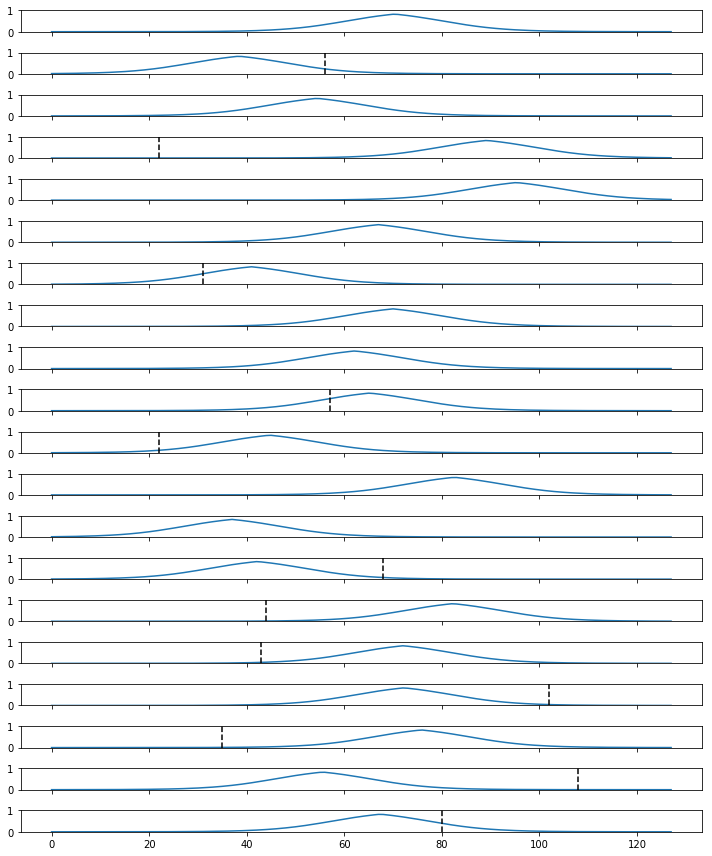

In [239]:
calc_attention_params = K.function([attention_model.input], [attention_params])
calc_attention = K.function([attention_model.input], [attention])

attention_params_values = calc_attention_params([X[:100]])[0]
attention_values = calc_attention([X[:100]])[0]

fig, axes = plt.subplots(20, 1, figsize=(10, 12), sharex=True)
for i in range(20):
    axes[i].plot(attention_values[i])
    if positions[i] >= 0:
        axes[i].plot([positions[i] + 4, positions[i] + 4], [0, 1], color='k', linestyle='dashed')
    axes[i].set_ylim(0, 1)
plt.tight_layout()

In [297]:
np.expand_dims(np.zeros((3, 4)), axis=1).shape

(3, 1, 4)

In [ ]:
def variational_autoencoder(window_size=128, n_channels=4, n_sampler=10, latent_size=2):
    def conv_network(input_layer):
        output = Conv1D(64, 8, padding='same', kernel_regularizer=l2(0.0005))(input_layer)
        output = Activation('relu')(output)
        output = MaxPooling1D(2)(output)
        output = Conv1D(64, 4, padding='same', kernel_regularizer=l2(0.0005))(output)
        output = Activation('relu')(output)
        output = MaxPooling1D(2)(output)
        output = Flatten()(output)
        return output

    def deconv_network(input_layer):
        output = UpSampling1D(2)(input_layer)
        output = Deconv1D(64, 4, padding='same', kernel_regularizer=l2(0.0005))(output)
        output = Activation('relu')(output)
        output = UpSampling1D(2)(output)
        output = Deconv1D(64, 8, padding='same', kernel_regularizer=l2(0.0005))(output)
        output = Activation('relu')(output)
        output = Deconv1D(4, 1, padding='same', kernel_regularizer=l2(0.0005))(output)
        output = Activation('sigmoid')(output)
        #output = Dense(64, kernel_regularizer=l2(0.0001))(output)
        return output
    
    input_layer = Input(shape=(window_size, n_channels))
    conv_out = conv_network(input_layer)
    
    latent_params = Dense(latent_size*2, name='latent_params')(conv_out)
    latent_mean = Lambda(lambda x: K.expand_dims(x[:latent_size], axis=1), name='latent_mean')(latent_params)
    latent_logstd = Lambda(lambda x: K.expand_dims(x[latent_size:], axis=1), name='latent_logsd')(latent_params)
    latent_var = Lambda(lambda x: K.square(K.exp(x)), name='latent_std')(latent_logstd)
    standard_sampler = Lambda(lambda x: K.random_normal((K.shape(x)[0], latent_size)),
                              name='standard_sampler')(input_layer)
    latent_sampler = Lambda(lambda x: x[0]*x[2] + x[1], 
                            name='latent_sampler')([standard_sampler, latent_mean, latent_std])
    latent = Lamda(lambda x: K.reshape((-1, latent_size)), name='latent')(latent_sampler)
    
    decoder_input = Dense(window_size//4*n_channels, name='latent_dense')(latent)
    decoder_input = Reshape((window_size, n_channels), name='latent_reshape')(decoder_input)
    output = deconv_network(decoder_input)
    

In [300]:
attention.shape[0]

Dimension(None)

2.384349332959165


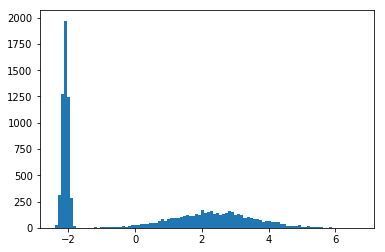

In [290]:
def gaussian_mixture_1d(loc=None, scale=None, c=None, k=2, size=1):
    if loc is None:
        loc = np.random.uniform(-3, 3, size=k)
    if scale is None:
        scale = np.random.gamma(1, size=k)
    if c is None:
        c = np.random.uniform(size=k) + 0.5
        c /= c.sum()
    x = np.empty((size, k))
    for i in range(k):
        x[:, i] = np.random.normal(loc=loc[i], scale=scale[i], size=size)
    delta = np.random.choice(k, size=size, p=c)
    x = x[np.r_[:size], delta]
    return x

x = gaussian_mixture_1d(k=2, size=10000)
h = plt.hist(x, bins=100)
print(np.std(x))